In [1]:
import torch
from pathlib import Path
import numpy as np
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt

Wed Apr  3 10:31:27 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 40%   56C    P2   123W / 250W |   9616MiB / 12036MiB |     95%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   28C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
plt.style.use('model/lhcb.mplstyle')

In [3]:
from model.models import AltCNN4Layer_D35_sp as Model
from model.collectdata import collect_data, collect_truth
from model.plots import plot_truth_vs_predict
from model.efficiency import efficiency, ValueSet, pv_locations, exact_efficiency
from model.training import select_gpu
from model.core import modernize_state

#### Device configuration

In [4]:
# device = select_gpu(2)
device = torch.device("cpu")

1 available GPUs (initially using device 0):
  0 TITAN V


#### Load a dataset

In [5]:
valfile = Path('/share/lazy/schreihf/PvFinder/Oct03_20K_val.h5')

Loading data...
Loaded /share/lazy/schreihf/PvFinder/Oct03_20K_val.h5 in 1.463 s
Constructing 10000 event dataset took 4.156 s


In [ ]:
validation = collect_data(valfile,
                          batch_size=1,
                          device=device,
                          slice=slice(20000),
                          masking=True)
                          

In [6]:
model = Model().to(device)

#### Load the model weights

Modernizing old style models if needed.

In [7]:
state = torch.load(
    '/share/lazy/schreihf/PvFinder/models/'
    '07Jan19_AltCNN4Layer_D35_sp_300epochs'
    '_240K_lr_3em5_bs256_Alt_Loss_A_5p5/'
    '07Jan19_AltCNN4Layer_D35_sp_300epochs'
    '_240K_lr_3em5_bs256_Alt_Loss_A_5p5_199.pyt'
)

SimpleCNN4Layer_D35_sp(
  (features): Sequential(
    (0): Conv1d(1, 25, kernel_size=(25,), stride=(1,), padding=(12,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.35)
    (3): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.35)
    (6): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.35)
    (9): Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.35)
  )
  (fc): Linear(in_features=4000, out_features=4000, bias=True)
)

In [ ]:
del state['fc1.weight'], state['fc1.bias']

In [ ]:
state = modernize_state(model, state)

In [ ]:
model.load_state_dict(state)
model.eval()

#### Compute the model and move results to Numpy

In [8]:
%%time
with torch.no_grad():
    outputs = model(validation.dataset.tensors[0]).cpu().numpy()
    labels = validation.dataset.tensors[1].cpu().numpy()

CPU times: user 290 ms, sys: 191 ms, total: 481 ms
Wall time: 562 ms


#### Compute the efficencies over the dataset

In [9]:
%%time
total = ValueSet(0,0,0,0)

for label, output in zip(labels, outputs):
    total += efficiency(label, output, 5., 1e-2, .2, 3)

CPU times: user 273 ms, sys: 331 µs, total: 273 ms
Wall time: 271 ms


In [10]:
print(total)
print()
print(total.pretty())

Found 49507 of 54804, added 5570 (eff 90.33%) (0.557 FP/event)

Real PVs in validation set: 54,804
Successes: Either 49,507 or 49,466, depending on how you count.
Missed true PVs: 5,297
False positives: 5,570
Efficiency of detecting real PVs: 90.33%
False positive rate: 0.557


#### Some examples of the counting algorithm:

In [11]:
for i in range(20):
    result = efficiency(labels[i], outputs[i], 5., 1e-2, .2, 3)
    print(format(i, '2'), result)

Found 4 of 4, added 1 (eff 100.00%)
Found 1 of 1, added 1 (eff 100.00%)
Found 4 of 5, added 1 (eff 80.00%)
Found 3 of 4, added 0 (eff 75.00%)
Found 5 of 5, added 1 (eff 100.00%)
Found 8 of 8, added 0 (eff 100.00%)
Found 7 of 7, added 0 (eff 100.00%)
Found 2 of 2, added 0 (eff 100.00%)
Found 3 of 3, added 0 (eff 100.00%)
Found 4 of 5, added 0 (eff 80.00%)
Found 5 of 5, added 1 (eff 100.00%)
Found 6 of 9, added 2 (eff 66.67%)
Found 6 of 6, added 2 (eff 100.00%)
Found 2 of 2, added 0 (eff 100.00%)
Found 5 of 5, added 0 (eff 100.00%)
Found 3 of 3, added 0 (eff 100.00%)
Found 6 of 6, added 0 (eff 100.00%)
Found 4 of 4, added 1 (eff 100.00%)
Found 3 of 4, added 0 (eff 75.00%)
Found 4 of 4, added 1 (eff 100.00%)


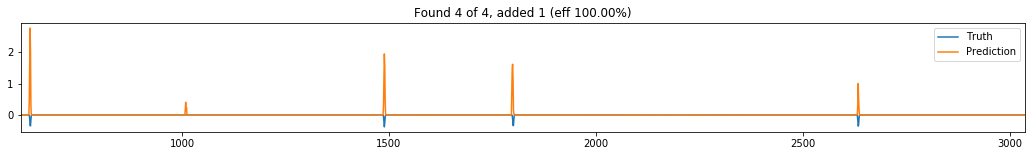

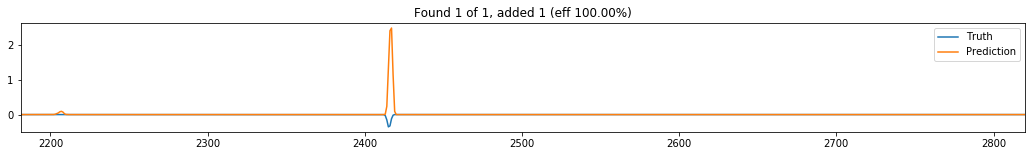

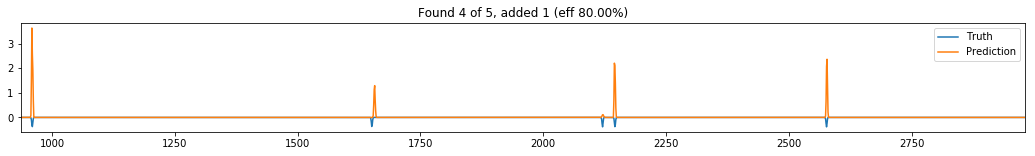

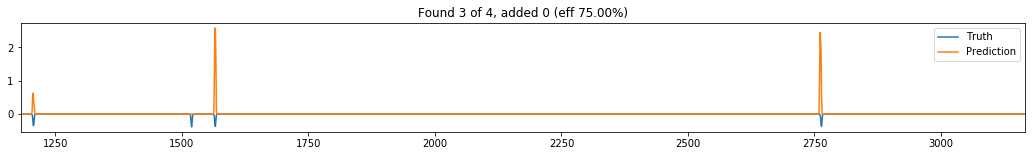

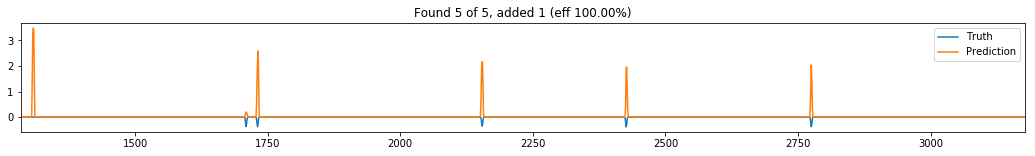

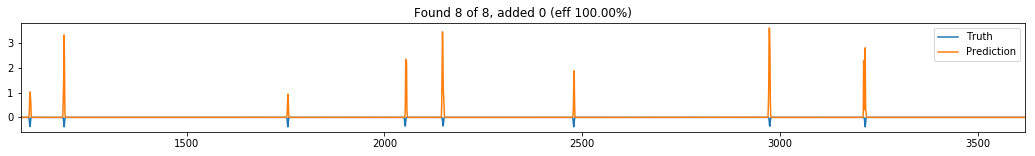

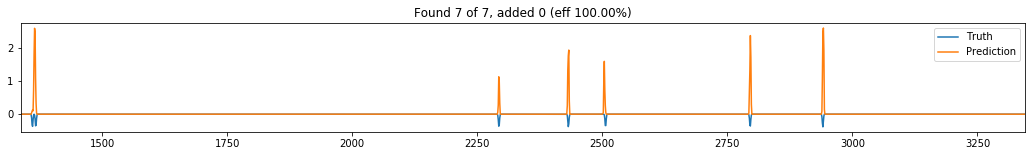

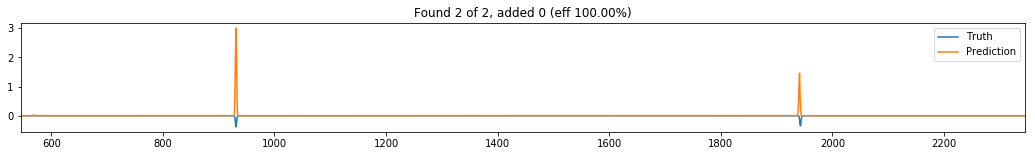

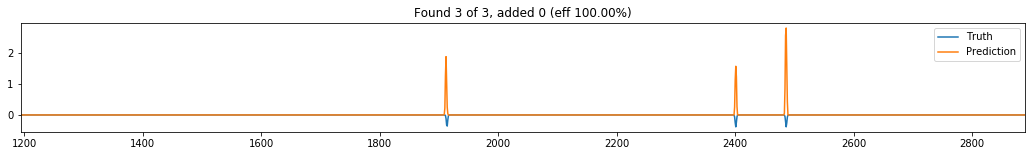

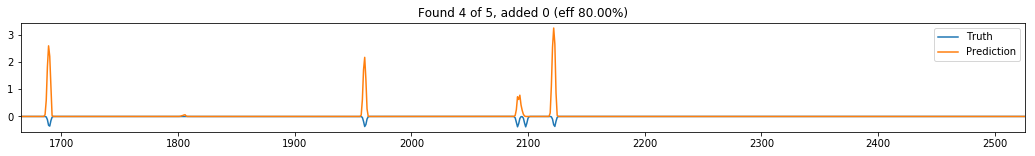

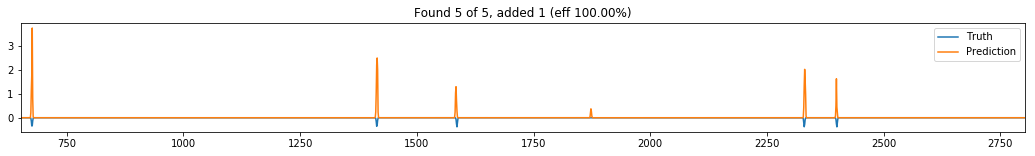

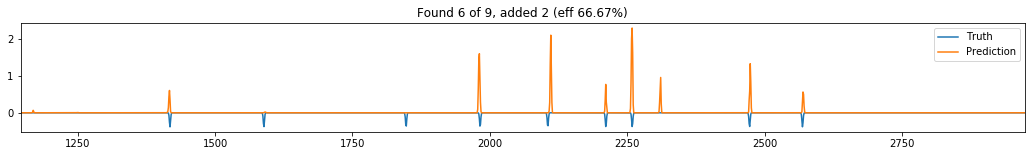

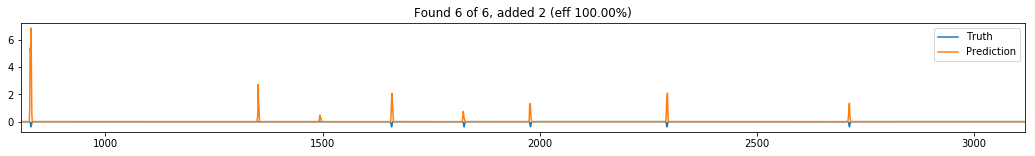

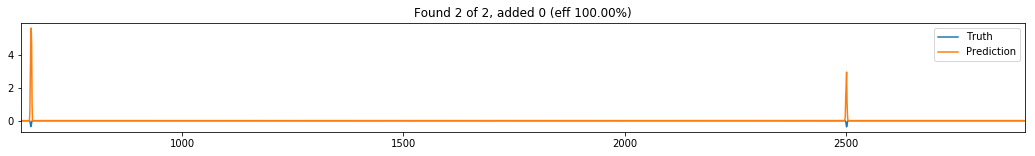

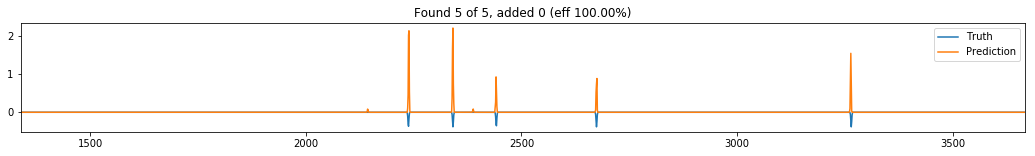

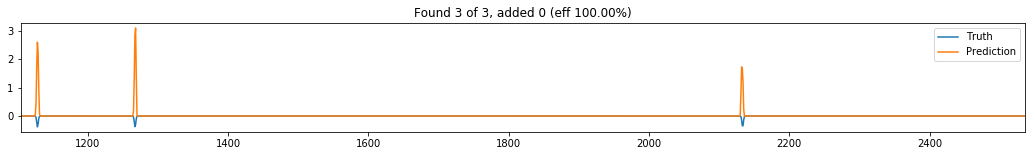

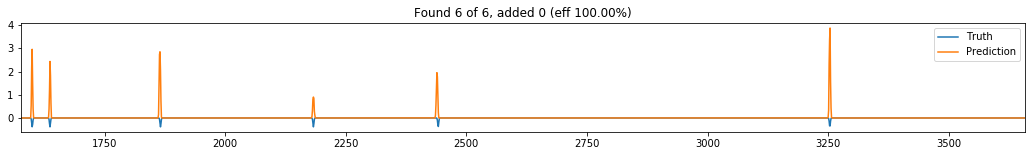

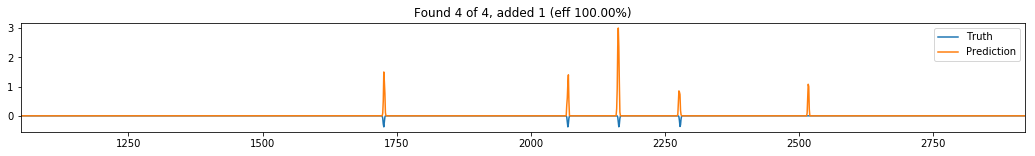

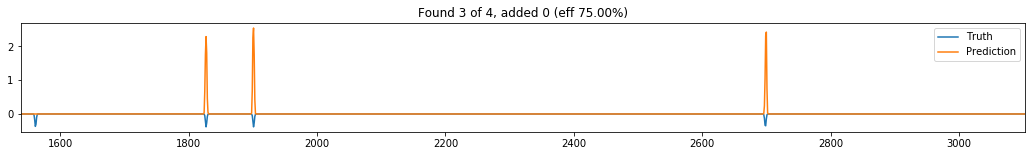

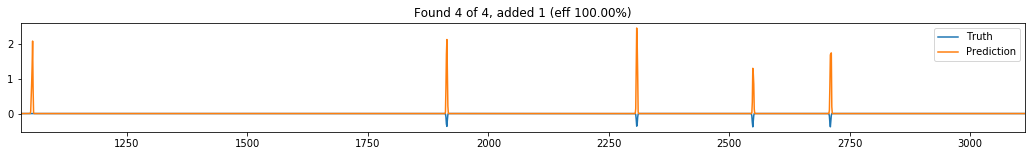

In [12]:
for i in range(20):
    result = efficiency(labels[i], outputs[i], 5., 1e-2,.2, 3)
    ax = plot_truth_vs_predict(labels[i], outputs[i])
    ax.set_title(str(result))

#### Adding nTracks

In [ ]:
truth = collect_truth(valfile)

In [ ]:
eff_settings = dict(
    difference = 5., # bins
    threshold = 1e-2,
    integral_threshold = .2,
    min_width = 3    # bins
)

eff_settings_nodiff = eff_settings.copy()
del eff_settings_nodiff['difference']

In [ ]:
i = 2

print(efficiency(labels[i], outputs[i], **eff_settings))

found_values = pv_locations(outputs[i], **eff_settings_nodiff)/10-100

valid = truth.n[i] > 4
zs = truth.z[i][valid]
ns = truth.n[i][valid]

print("Found nTracks Location\tDistance")
for z,n in zip(zs, ns):
    closest = np.min(np.abs(z - found_values))
    found = closest < eff_settings['difference']/10
    print(f"{found!s:5} {n:7} {z:8.5}  {closest:8.5}")
    
target_values = pv_locations(labels[i], **eff_settings_nodiff)/10-100
target_values

In [ ]:
for i in range(100):

    eff = efficiency(labels[i], outputs[i], **eff_settings)

    found_values = pv_locations(outputs[i], **eff_settings_nodiff)/10-100

    valid = truth.n[i] > 4
    zs = truth.z[i][valid]
    ns = truth.n[i][valid]

    total_found = 0
    for z,n in zip(zs, ns):
        closest = np.min(np.abs(z - found_values))
        found = closest < eff_settings['difference']/10
        total_found += found
        
    if total_found != eff.S:
        print(i, total_found, eff.S)

In [ ]:
total_found, pvs_successful, pvs_failed = exact_efficiency(truth, outputs, **eff_settings)

In [ ]:
fr = (total_found - total.S) / ((total_found + total.S) / 2)
print(f'Fractional difference between the two methods: {fr:.2%}')

In [ ]:
# Found 49507 of 54804, added 5570 (eff 90.33%) (0.557 FP/event)
print(total)
print(f'Found {total_found} of {total.real_pvs} (eff {total_found/total.real_pvs:.2%})')

In [ ]:
arr_successful = np.array([pvs_successful[i] for i in range(100)])
arr_failed = np.array([pvs_failed[i] for i in range(100)])

In [ ]:
arr_totals = arr_successful + arr_failed
arr_totals = np.ma.array(arr_totals, mask=arr_totals==0)

arr_eff = arr_successful / arr_totals

In [ ]:
print(arr_eff[:61])
print(arr_totals[:61])

In [ ]:
np.savetxt('talks/arr_eff_sym.txt', arr_eff)
np.savetxt('talks/arr_totals_sym.txt', arr_totals)
import pickle
pickle.dumps(total)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(14,7), gridspec_kw={'height_ratios':(2,1)})

ax1.bar(np.arange(5,61), arr_eff[5:61], width=1, align='edge')
ax1.bar(np.arange(5), arr_eff[:5], width=1, align='edge')
ax1.set_xlabel('# LHCb long tracks')
ax1.set_ylabel('Efficiency')
ax1.set_ylim(0,1.0)
ax1.set_xlim(0,61)
ax1.set_yticks(np.arange(11)/10)
ax1.set_yticks([.95,.96,.97,.98,.99],minor=True)
ax1.set_xticks(np.arange(0,61,5))
ax1.grid(which='both')

ax2.bar(np.arange(5,61), arr_totals[5:61], width=1, align='edge')
ax2.bar(np.arange(5), arr_totals[:5], width=1, align='edge')
ax2.set_xlabel('# LHCb long tracks')
ax2.set_ylabel('PVs')
ax2.set_xlim(0,61)
ax2.set_ylim(50,20000)
ax2.set_yscale('log')
ax2.set_xticks(np.arange(0,61,5))
ax2.grid(which='both')

# these are matplotlib.patch.Patch properties
# total_found could be used instead of total.S
props = dict(boxstyle='round', facecolor='C2')
textprops = dict(color='C0', multialignment='left')
textstr = f'''\
Found {total.S} of {total.real_pvs} (eff {total.S/total.real_pvs:.2%})
False positive rate = {total.fp_rate:.3} per event
Events in sample = 20K
Training sample = 240K'''

# place a text box in upper left in axes coords
ax1.text(0.95, 0.9, textstr, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='right', bbox=props, fontdict=textprops)

plt.tight_layout()
#plt.savefig('effntracks.pdf')
plt.show()